In [1]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import r2_score, auc, roc_curve, roc_auc_score, log_loss, fbeta_score,precision_recall_curve

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
class AnomalyDetector(Model):
    def __init__(self, num_input_features):
        super(AnomalyDetector, self).__init__()
        self.num_input = num_input_features

        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(self.num_input, activation="linear")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
### Test running the model
loss = 'mean_squared_error'
TIME_STEPS = 24
BATCH_SIZE = 16
num_features = 2

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')


In [61]:
### Load the data ###
data, varnames, target = dp.load_data_nn('3-jk', sensor='both', dlh=0, 
                                         keep_SH=False, return_target=True, smote=None)

The beginning shape is:  (10221, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (10011, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (10011, 48)
The right data frame set shape is:  (10011, 48)
The keep left data frame set shape is:  (10011, 24)
The keep right data frame set shape is:  (10011, 24)
Not adding fake positive data samples.


In [62]:
### Split the data into train, val, and testing
target = np.where(target == 1, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,target)

# Prepare data for the autoencoder model
normal, anomalous = dp.process_autoencoder(data[train_idx], data[test_idx], data[val_idx],
                                           target[train_idx], target[test_idx], target[val_idx])

normal_train, normal_val, normal_train_target, normal_val_target             = normal
anomalous_train, anomalous_val, anomalous_train_target, anomalous_val_target = anomalous

# Try Normalizing the data
#scaled_normal_train, scaled_test, scaled_normal_val = dp.normalize_data(normal_train, data[test_idx], normal_val)

train_data = normal_train # scaled_normal_train #
y_train    = normal_train_target

test_data  = data[test_idx] #scaled_test #
y_test     = target[test_idx]

val_data   = normal_val #scaled_normal_val #
y_val      = normal_val_target

print("Anomalous train data shape is: ", anomalous_train.shape)
print("Anomalous val data shape is: ", anomalous_val.shape)

Train labels shape:  (2380,)
Test labels shape:  (5836,)
Val labels shape:  (1795,)
Normal train data shape is:  (2345, 48)
Normal test data shape is:  (5824, 48)
Normal val data shape is:  (1783, 48)
Anomalous train data shape is:  (35, 48)
Anomalous test data shape is:  (12, 48)
Anomalous val data shape is:  (12, 48)
Anomalous train data shape is:  (35, 48)
Anomalous val data shape is:  (12, 48)


In [79]:
# Test single model
autoencoder = AnomalyDetector(48) #, timesteps) #nnm.AnomalyDetector(data.shape[1])

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='mean_squared_error')
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = autoencoder.fit(train_data, train_data,
          epochs=5000, callbacks = [early_stopping],
          validation_split=0.1, batch_size=BATCH_SIZE)
          #validation_data=(val_data, val_data))

Epoch 1/5000
132/132 [==============================] - 1s 3ms/step - loss: 14724.3438 - val_loss: 14123.2490
Epoch 2/5000
132/132 [==============================] - 0s 2ms/step - loss: 12411.6221 - val_loss: 8682.5898
Epoch 3/5000
132/132 [==============================] - 0s 2ms/step - loss: 5492.1177 - val_loss: 2807.3889
Epoch 4/5000
132/132 [==============================] - 0s 2ms/step - loss: 2026.6740 - val_loss: 1245.5853
Epoch 5/5000
132/132 [==============================] - 0s 2ms/step - loss: 1207.3499 - val_loss: 919.3978
Epoch 6/5000
132/132 [==============================] - 0s 2ms/step - loss: 1032.7610 - val_loss: 849.4770
Epoch 7/5000
132/132 [==============================] - 0s 2ms/step - loss: 992.9718 - val_loss: 840.7889
Epoch 8/5000
132/132 [==============================] - 0s 2ms/step - loss: 977.8335 - val_loss: 827.2780
Epoch 9/5000
132/132 [==============================] - 0s 2ms/step - loss: 960.5747 - val_loss: 809.4600
Epoch 10/5000
132/132 [==========

<AxesSubplot:title={'center':'ANN Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

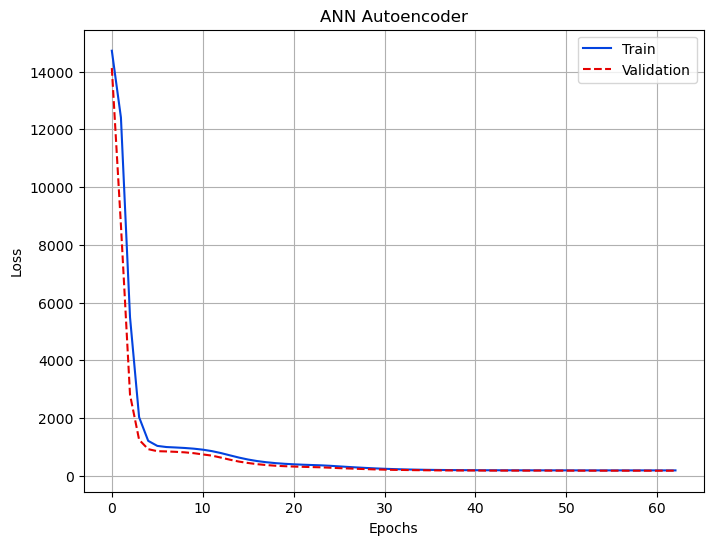

In [80]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'ANN Autoencoder')

In [81]:
class ThresholdEstimator:

    def __init__(self) -> None:
        self.mu        = 0
        self.sigma     = 1
        self.threshold = None

    def fit(self, model, data, target):

        # Reconstruct the data
        reconstructions = model.predict(data)
        print("Reconstructions:")
        print(reconstructions[:5, :5])
        print("Data:")
        print(data[:5, :5])
        if len(data.shape) == 3:
            errors = tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data))
        else:
            errors = tf.keras.losses.mse(reconstructions, data)
        
        # Estimate the normal distribution of the errors
        self.mu    = np.mean(errors, axis = 0)
        self.sigma = np.cov(errors)

        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        likelihoods  = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        print("Likelihoods:")
        print(likelihoods[:5])

        f_list = []
        
        #step_size = int((max(likelihoods) - min(likelihoods)) / 1000) # Too small for arange
        thresholds = np.linspace(min(likelihoods), max(likelihoods), 100)
        
        for t in thresholds:

            preds = (likelihoods<t).astype(int)
            f = fbeta_score(target, preds, beta=0.1)
            f_list.append(f)

        bidx = np.argmax(f_list)
        self.best_threshold = thresholds[bidx]
        #self.best_threshold = np.max(errors)
        #self.best_threshold = np.quantile(errors, 0.95) #thresholds[bidx]

        return self
    
    def _compress_array(self, array):
        compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
        return compressed_array
    
    def predict(self, model, data, target):
        
        reconstructions = model.predict(data)
        if len(data.shape) == 3:
            errors = np.array(tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data)))
        else:
            errors = np.array(tf.keras.losses.mse(reconstructions, data))
        print(errors[:5])
        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        #likelihoods = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        likelihoods = np.array(errors)
        print(likelihoods[:5])
        
        pred_labels = (likelihoods < self.best_threshold).astype(int)
        #likelihoods = errors
        #pred_labels = (errors > self.best_threshold).astype(int)
        return likelihoods, pred_labels

In [82]:
# Fit the threshold using the validation dataset.
ter = ThresholdEstimator()

ter.fit(autoencoder, val_data, y_val)

56/56 [==============================] - 0s 937us/step
Reconstructions:
[[89.87833  89.51541  88.718704 86.059395 83.32718 ]
 [80.44354  80.19341  79.456985 77.06179  74.75555 ]
 [75.54377  75.32729  74.32694  71.59038  69.350784]
 [72.69515  72.35478  71.1714   68.397934 65.98799 ]
 [69.934135 69.514336 68.33498  65.81993  63.38394 ]]
Data:
[[105.2  97.8  83.2  76.   74.2]
 [ 97.8  83.2  76.   74.2  68.4]
 [ 83.2  76.   74.2  68.4  62.2]
 [ 76.   74.2  68.4  62.2  58.6]
 [ 74.2  68.4  62.2  58.6  58. ]]
Likelihoods:
[2.59359526e-05 2.59356848e-05 2.59354614e-05 2.59354110e-05
 2.59353824e-05]


/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [83]:
test_preds, test_labels = ter.predict(autoencoder, test_data, y_test)

fpr_test, tpr_test, thresh_test = roc_curve(y_test, test_preds)
ppr_test, rec_test, pthresh_test = precision_recall_curve(y_test, test_preds)

print("Test AU-ROC: ", auc(fpr_test, tpr_test))
print("Test AU-PRC: ", auc(rec_test, ppr_test))
print("F-0.1 Score: ", fbeta_score(y_test, test_labels, beta=0.1))

183/183 [==============================] - 0s 911us/step
[126.89018882 150.28645716 145.3696936  117.94378026  82.23731433]
[126.89018882 150.28645716 145.3696936  117.94378026  82.23731433]
Test AU-ROC:  0.46709020146520147
Test AU-PRC:  0.0017759308052914546
F-0.1 Score:  0.0


In [84]:
# Recombine full train and val data for testing
full_train_data, full_y_train = data[train_idx], target[train_idx]
full_val_data,   full_y_val   = data[val_idx], target[val_idx]

In [85]:
# Predict Train data
train_preds, train_labels = ter.predict(autoencoder, full_train_data, full_y_train)

fpr_train, tpr_train, thresh_train  = roc_curve(full_y_train, train_preds)
ppr_train, rec_train, pthresh_train = precision_recall_curve(full_y_train, train_preds)

print("Test AU-ROC: ", auc(fpr_train, tpr_train))
print("Test AU-PRC: ", auc(rec_train, ppr_train))
print("F-0.1 Score: ", fbeta_score(full_y_train, train_labels, beta=0.1))

75/75 [==============================] - 0s 879us/step
[196.37830154 165.9547656  176.91050454 219.32026447 257.08732079]
[196.37830154 165.9547656  176.91050454 219.32026447 257.08732079]
Test AU-ROC:  0.44760280231495575
Test AU-PRC:  0.012031126468196889
F-0.1 Score:  0.0


In [86]:
# Predict Validation data
val_preds, val_labels = ter.predict(autoencoder, full_val_data, full_y_val)

fpr_val, tpr_val, thresh_val  = roc_curve(full_y_val, val_preds)
ppr_val, rec_val, pthresh_val = precision_recall_curve(full_y_val, val_preds)

print("Validation AU-ROC: ", auc(fpr_val, tpr_val))
print("Validation AU-PRC: ", auc(rec_val, ppr_val))
print("F-0.1 Score: ", fbeta_score(full_y_val, val_labels, beta=0.1))

57/57 [==============================] - 0s 914us/step
[195.21699539  85.57318503  47.9085071   26.33798301  22.05827902]
[195.21699539  85.57318503  47.9085071   26.33798301  22.05827902]
Validation AU-ROC:  0.5103290334641989
Validation AU-PRC:  0.006519261452925782
F-0.1 Score:  0.0


In [87]:
anomalous_val

array([[101.8       , 103.6       , 106.4       , 112.6       ,
        117.2       , 119.6       , 120.        , 117.6       ,
        111.4       , 109.2       , 110.6       , 107.        ,
        105.2       ,  97.8       ,  83.2       ,  76.        ,
         74.2       ,  68.4       ,  62.2       ,  58.6       ,
         58.        ,  56.4       ,  49.6       ,  41.6       ,
        132.        , 134.        , 137.        , 142.        ,
        147.        , 154.        , 160.        , 157.        ,
        156.        , 161.        , 159.        , 147.        ,
        134.        , 112.        ,  88.        ,  74.        ,
         68.        ,  73.        ,  83.        ,  78.        ,
         75.        ,  73.        ,  63.        ,  57.        ],
       [250.        , 232.6       , 210.4       , 194.        ,
        176.6       , 157.        , 138.6       , 125.4       ,
        119.8       , 116.6       , 112.8       , 108.8       ,
        102.4       ,  93.        ,  87